# Temperate Analysis of Cage Conditions

> Statistical Analysis of running environment conditions, measured by sensor.

## Prepare Data

In [1]:
import pandas as pd
df = pd.read_json("http://10.0.0.13:3001/data/readings/1440")

# Mutate Array
rolling_window=60
df['average_temp'] = df.iloc[:,1].rolling(window=rolling_window).mean()
df['average_humid'] = df.iloc[:,2].rolling(window=rolling_window).mean()
df = df[['timestamp','temperature','humidity','average_temp','average_humid','id']]
df.tail(5)
# df.describe()

,timestamp,temperature,humidity,average_temp,average_humid,id
1435,2021-01-15 09:47:43,67.545434,61.782254,67.022637,63.439892,103796
1436,2021-01-15 09:48:43,67.545434,61.869230,67.045548,63.408967,103797
1437,2021-01-15 09:49:43,67.521401,64.093996,67.067178,63.393835,103798
1438,2021-01-15 09:50:44,67.545434,62.917525,67.088808,63.386104,103799
1439,2021-01-15 09:51:44,67.545434,60.012207,67.110838,63.305079,103800


## Plot Data

### Line Plot with Quartiles

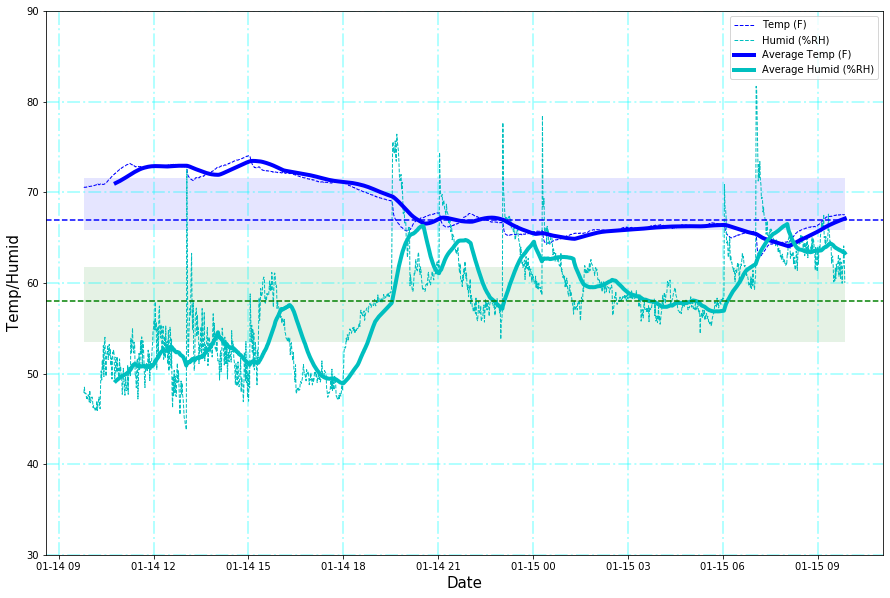

In [2]:
# Time plot with moving average
import numpy as np
import matplotlib.pyplot as plt


df = df[['timestamp','temperature','humidity','average_temp','average_humid']]

# First convert the index to datetime
df.index = pd.DatetimeIndex(df.timestamp)

# Plot Data
rolling_window=60
fig = plt.figure(figsize=[15,10])
ax = plt.axes()
line1, = plt.plot(df.temperature, 'b--', linewidth=1, label='Temp (F)')
line2, = plt.plot(df.humidity, 'c--', linewidth=1, label='Humid (%RH)')
line3, = plt.plot(df.average_temp, 'b-', linewidth=4, label='Average Temp (F)')
line4, = plt.plot(df.average_humid, 'c-', linewidth=4, label='Average Humid (%RH)')
plt.ylim(30, 90)

# Bands, Statistic Percentiles
humid_mean = np.percentile(df.humidity, 50)
humid_1sigma = [np.percentile(df.humidity, 25), np.percentile(df.humidity, 75)]
plt.fill_between([df.index[0], df.index[len(df.timestamp)-1]], humid_1sigma[0], humid_1sigma[1], facecolor='green', alpha=0.1, label="Humidity Center Quartiles")
plt.axhline(y=humid_mean, color='green', linestyle='--')

temp_mean = np.percentile(df.temperature, 50)
temp_1sigma = [np.percentile(df.temperature, 25), np.percentile(df.temperature, 75)]
plt.fill_between([df.index[0], df.index[len(df.timestamp)-1]], temp_1sigma[0], temp_1sigma[1], facecolor='blue', alpha=0.1, label="Temperature Center Quartiles")
plt.axhline(y=temp_mean, color='blue', linestyle='--')

# Labels and Legend
plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Temp/Humid', fontsize=15)
plt.legend(handles=[line1, line2, line3, line4], loc='best')
plt.show()

### Scatter Plot with Target Regions for Day and Night

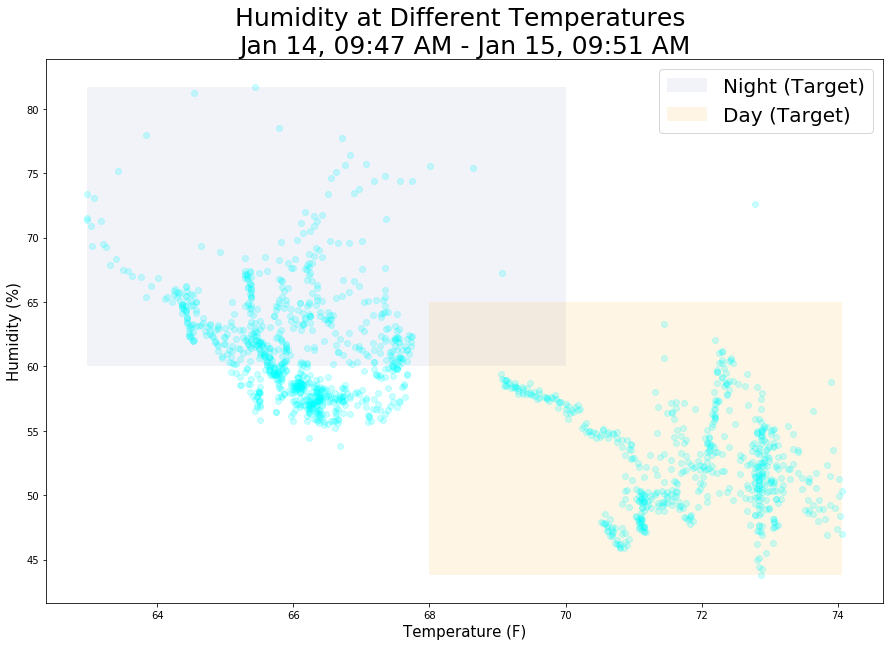

In [3]:
# Scatter Plot Humidity over Temperature
import time as datetime
x = df['temperature']
y = df['humidity']

xlim = [[max(x.min(), 62), min(x.max(), 70)], [max(x.min(), 68), min(x.max(), 75)]]
ylim = [[max(y.min(), 60), min(y.max(), 100)],[max(y.min(), 40), min(y.max(), 65)]]

timeformat = '%b %d, %H:%M %p'
title2 = (df['timestamp'][0]).strftime(timeformat) + " - " + (df['timestamp'][-1]).strftime(timeformat)
df_sub = df[['temperature', 'humidity']]
daterange = df['timestamp'][0],df['timestamp'][-1] 
fig = plt.figure(figsize=[15,10])

b0 = plt.fill_between(xlim[0], ylim[0][0], ylim[0][1], facecolor='darkblue', alpha=0.05, label="Night (Target)")
b1 = plt.fill_between(xlim[1], ylim[1][0], ylim[1][1], facecolor='orange', alpha=0.1, label="Day (Target)")

plt.scatter (x, y, s = None, alpha=.2, color='aqua')
plt.xlabel('Temperature (F)', fontsize=15)
plt.ylabel('Humidity (%)', fontsize=15)
plt.title('Humidity at Different Temperatures \n' + title2, fontsize=25)
plt.legend(handles=[b0, b1], loc='best', fontsize=20)

plt.show()


### Histograms, Day and Night

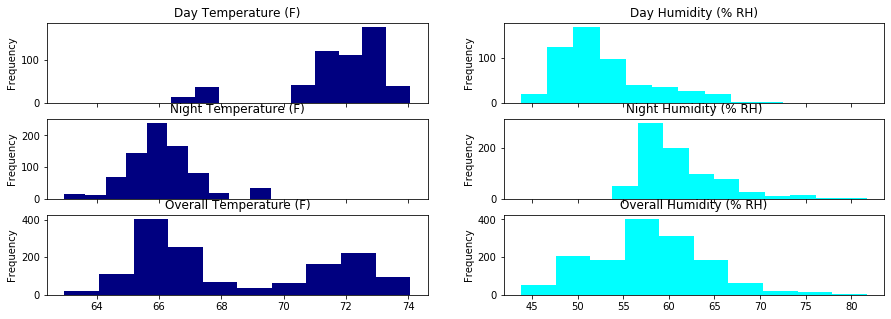

In [4]:
# Histograms Night and Day
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
x = df['timestamp']
h = df['humidity']
t = df['temperature']

df['hour'] = pd.DatetimeIndex(df['timestamp']).hour.values.astype(float)
day_filt = (df['hour']<18) & (df['hour']>8)
night_filt = (df['hour']>18) | (df['hour']<8)

fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col', figsize=[15,5])

day_tmp_zeros = df['temperature']*day_filt
day_hmd_zeros = df['humidity']*day_filt
night_tmp_zeros = df['temperature']*night_filt
night_hmd_zeros = df['humidity']*night_filt
day_tmp = day_tmp_zeros[day_tmp_zeros>0]
day_hmd = day_hmd_zeros[day_hmd_zeros>0]
night_tmp = night_tmp_zeros[night_tmp_zeros>0]
night_hmd = night_hmd_zeros[night_hmd_zeros>0]

(day_tmp).plot.hist(title='Day Temperature (F)', colormap='jet', ax=axs[0, 0])
(night_tmp).plot.hist(title='Night Temperature (F)', colormap='jet', ax=axs[1, 0])
df['temperature'].plot.hist(title='Overall Temperature (F)', colormap='jet', ax=axs[2, 0])

(day_hmd).plot.hist(title='Day Humidity (% RH)', colormap='cool', ax=axs[0, 1])
(night_hmd).plot.hist(title='Night Humidity (% RH)', colormap='cool', ax=axs[1, 1])
df['humidity'].plot.hist(title='Overall Humidity (% RH)', colormap='cool', ax=axs[2, 1])
plt.show()


### Statitical Distributions, Day vs. Night (Combined)

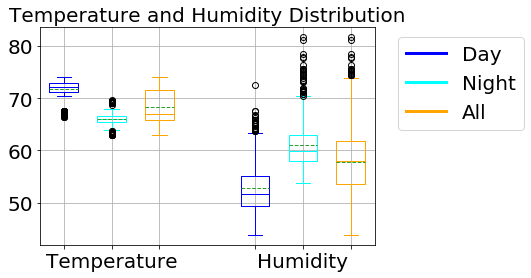

In [5]:
# Boxplot
from matplotlib.lines import Line2D

# Formatting
colors = ('blue', 'aqua', 'orange')
labels = ('Day', 'Night', 'All')
title = 'Temperature and Humidity Distribution'
tick_order = [' ', ' ', 'Temperature', 'Humidity', ' ', ' ']
options = { 'showmeans': True, 'meanline': True, 'widths': 0.6, 'fontsize': 20, 'rot': 90,
           'showcaps': True, 'showbox': True, 'showfliers': True 
          }

# Data
df_night = pd.DataFrame({'temp': night_tmp, 'humid': night_hmd})
df_day = pd.DataFrame({'temp': day_tmp, 'humid': day_hmd})
df_all = pd.DataFrame({'temp': df['temperature'], 'humid': df['humidity']})

# Plot Series
ax = df_day.boxplot( color=colors[0], positions = [0, 4], **options )
ax = df_night.boxplot( color=colors[1], positions = [1, 5], **options )
ax = df_all.boxplot( color=colors[2], positions = [2, 6], **options )

# Legends and Labels
ax.set_xticklabels(tick_order, rotation='horizontal')
ax.set_title(title, fontsize=20)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
plt.legend(lines, labels, fontsize=20, bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()


### Statitical Distributions, Day vs. Night vs. Overall

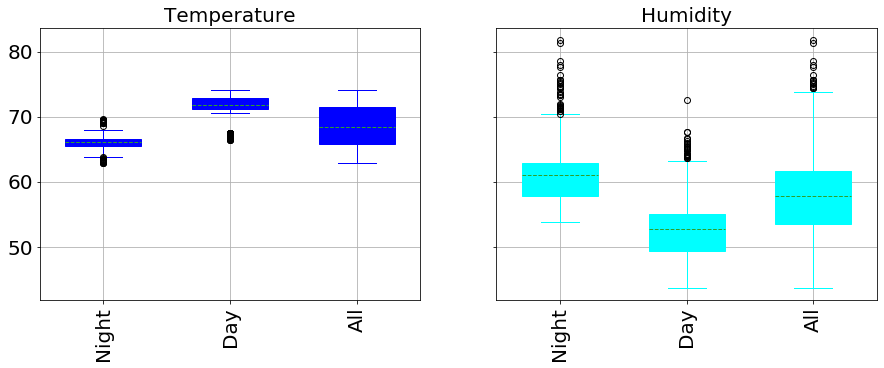

In [6]:
#Boxplots

#Formatting
options = { 'showmeans': True, 'meanline': True, 'widths': 0.6, 'fontsize': 20, 'rot': 90,
           'showcaps': True, 'showbox': True, 'showfliers': True
          }
colors = ('blue', 'aqua')
series = ('Night', 'Day', 'All')
titles = ['Humidity', 'Temperature']

# Series
df_temp = pd.DataFrame({'night': night_tmp, 'day': day_tmp, 'all': df['temperature']})
df_humid = pd.DataFrame({'night': night_hmd, 'day': day_hmd, 'all': df['humidity']})
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15,5], sharey='row',)

p1 = df_humid.boxplot(figsize=(20,10),patch_artist=True, ax=axs[1], **options, color=colors[1])
p0 = df_temp.boxplot(figsize=(20,10),patch_artist=True, ax=axs[0], **options, color=colors[0])


#Labeling
p1.set_title(titles[0], fontsize=20)
p0.set_title(titles[1], fontsize=20)
p1.set_xticklabels(series)
p0.set_xticklabels(series)
plt.show()
